In [1]:
# 필요한 라이브러리들 import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

2000-2001, 2002-2013, 2014 데이터 모두 컬럼명 일치

#### 데이터 설명

1. 핵심 지표
- OPS (On-base Plus Slugging) : 출루율 + 장타율, 타자의 종합 공격 생산성을 나타내는 대표 지표
 
- wOBA (Weighted On-Base Average) : 이벤트별 가중치를 적용한 출루 지표, 실제 득점 기여와 가장 높은 상관
 
2. 파워 평가 지표
 
- HR (Home Run) : 홈런 개수, 장타력과 결정력을 직접적으로 보여주는 지표
 
- ISO (Isolated Power) : 장타율 − 타율, 순수 장타 능력만 분리해 평가하는 지표
 
3. 득점 생산 지표
 
- RC (Runs Created) : 해당 선수가 만들어낸 득점 기대값, 공격 기여도를 점수화한 지표
 
- RC/27 : 한 팀이 그 선수 9명으로 구성됐을 때의 경기당 득점 기대치, 리그 평균 대비 공격력 비교용
 
4. 보조 평가 지표
 
- SECA (Secondary Average) : (루타 − 안타 + 볼넷 + 도루) 기반 지표, 타율에 포함되지 않는 공격 기여도 평가
 
- TA (Total Average) : 모든 공격 이벤트를 종합한 타격 지표, 출루·장타·주루를 함께 반영
 
- XR (Extrapolated Runs) : 득점 생산력을 추정한 지표로, RC와 유사하나 주루·아웃 가치 반영이 더 세밀

### 데이터 불러오기 및 전처리

In [2]:
# csv를 읽어와서 Pandas DataFrame으로 저장
df_00_01 = pd.read_csv('./data/2000_2001_hitter.csv')
df_00_01.head()

,YrPlayer,Year,Rank,Player,Team,AVG,G,PA,AB,H,...,OBP,SLG,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR
0,2000박종호,2000,1,박종호,현대,0.340,121,541,441,150,...,0.428023,0.489796,0.917819,0.149660,0.297052,0.976667,100.354529,8.286154,0.400138,92.804
1,2000김동주,2000,2,김동주,두산,0.339,127,539,469,159,...,0.413729,0.603412,1.017141,0.264392,0.379531,1.063830,115.473840,9.306847,0.431993,105.000
2,2000브리또,2000,3,브리또,SK,0.338,103,452,405,137,...,0.398664,0.533333,0.931997,0.195062,0.274074,0.931655,86.204956,8.224501,0.400969,77.820
3,2000송지만,2000,4,송지만,한화,0.338,120,530,468,158,...,0.409434,0.621795,1.031229,0.284188,0.423077,1.110092,119.916981,9.811389,0.436688,107.594
4,2000데이비스,2000,5,데이비스,한화,0.334,107,458,419,140,...,0.367033,0.565632,0.932665,0.231504,0.324582,0.923588,82.605677,7.125729,0.394586,80.284


In [3]:
#파일을 합치기
df_02_13 = pd.read_csv('./data/2002_2013_hitter.csv')
df_14 = pd.read_csv('./data/2014_hitter.csv')

In [4]:
df_combined = pd.concat( [df_00_01, df_02_13, df_14], ignore_index=True)
df_combined.sample(5)

,YrPlayer,Year,Rank,Player,Team,AVG,G,PA,AB,H,...,TA,RC,RC/27,wOBA,XR,R,SAC,MH,RISP,PH-BA
616,2014유한준,2014,23,유한준,넥센,0.316,122,469,405,128,...,0.937282,85.664947,7.658787,0.395113,80.546,71.0,8.0,38.0,0.328,0.167
530,2012강민호,2012,25,강민호,롯데,0.273,119,454,400,109,...,0.790698,66.865727,5.958332,0.356843,64.604,41.0,0.0,27.0,0.265,0.250
566,2013박정권,2013,21,박정권,SK,0.292,110,434,363,106,...,0.928571,75.699539,7.514292,0.383441,72.558,56.0,0.0,25.0,0.262,0.500
108,2002김종국,2002,20,김종국,KIA,0.287,133,595,527,151,...,0.800000,85.034824,5.827259,0.336179,82.112,95.0,3.0,41.0,0.298,1.000
338,2007진갑용,2007,41,진갑용,삼성,0.246,122,427,362,89,...,0.604240,42.592974,3.938391,0.301317,43.856,28.0,5.0,26.0,0.227,0.000


In [5]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 41 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YrPlayer  649 non-null    object 
 1   Year      649 non-null    int64  
 2   Rank      649 non-null    int64  
 3   Player    649 non-null    object 
 4   Team      649 non-null    object 
 5   AVG       649 non-null    float64
 6   G         649 non-null    int64  
 7   PA        649 non-null    int64  
 8   AB        649 non-null    int64  
 9   H         649 non-null    int64  
 10  1B        649 non-null    int64  
 11  2B        649 non-null    int64  
 12  3B        649 non-null    int64  
 13  HR        649 non-null    int64  
 14  RBI       649 non-null    int64  
 15  SB        648 non-null    float64
 16  CS        648 non-null    float64
 17  BB        649 non-null    int64  
 18  HBP       649 non-null    int64  
 19  SO        649 non-null    int64  
 20  GDP       649 non-null    int64 

일단 선수 역량 분석에 영향을 주는 지표들만 골라서 확인해보기

In [6]:
# 변수 선택
X = df_combined[['HR','OPS','ISO','SECA','TA','RC','RC/27','wOBA','XR']]
y = df_combined['YrPlayer'] # 몇 년도 선수인지 구분하기 위함

print(X.shape, y.shape)
X.head()
y.head()

(649, 9) (649,)


0     2000박종호 
1     2000김동주 
2     2000브리또 
3     2000송지만 
4    2000데이비스 
Name: YrPlayer, dtype: object

<Axes: >

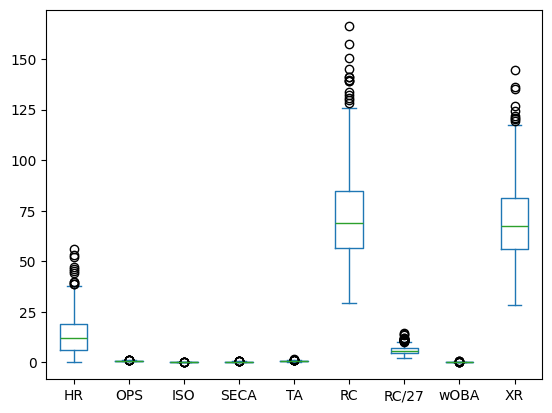

In [7]:
# 데이터 분포 확인(박스플롯)
X.plot(kind='box') 

=> 스케일링하거나 아웃라이어에 강건한 DBSCAN을 사용하면 좋을 것 같다!

여기서는 표준 스케일러 사용

In [8]:
# 데이터 스케일링 
X_scaled = StandardScaler().fit_transform(X)
X_scaled

array([[-0.3731278 ,  0.97614887, -0.07422939, ...,  1.20484091,
         1.11880719,  1.21433377],
       [ 1.81506444,  1.89711625,  1.67989079, ...,  1.75823146,
         1.89486616,  1.85744936],
       [ 0.14787035,  1.10761611,  0.61991005, ...,  1.1714146 ,
         1.13904003,  0.42420225],
       ...,
       [-0.58152706, -0.42233048, -0.05169927, ..., -0.32541846,
        -0.43538549, -0.33597768],
       [-1.20672484, -1.46085838, -1.39601302, ..., -1.37885116,
        -1.47288829, -1.11957047],
       [-1.10252521, -1.28467954, -1.24146838, ..., -1.19083305,
        -1.21125882, -1.3345048 ]], shape=(649, 9))

<Axes: >

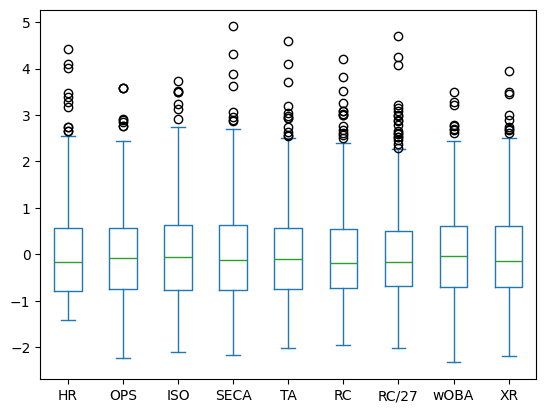

In [9]:
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.plot(kind='box')

### K-means (PCA 전)

#### 최적의 k 찾기(PCA 전)

1. 엘보우 기법
2. 실루엣 점수 시각화

5841.000000000001
2554.0730064648387
1599.3439555364587
1249.6842092971824
1062.0578691412325
928.7417220776362
845.2619972199252
791.1998175982177
742.9937575490478
678.426578564148


Text(0.5, 1.0, 'Elbow Method (k=1 to 9)')

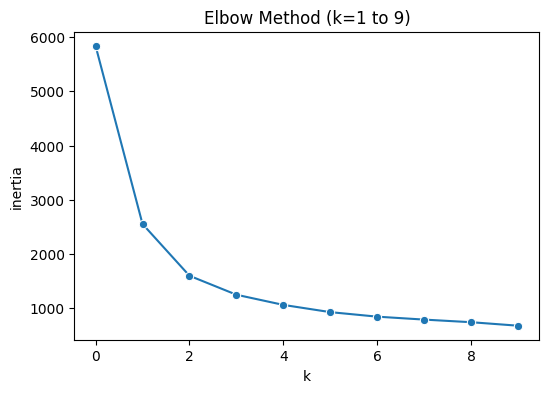

In [10]:
# 엘보우 기법으로 최적의 k 찾기
inertia = []
range_k = range(1, 11)
for n in range_k:
    km = KMeans(n_clusters=n, random_state=42) # random_state 고정
    km.fit(X_scaled)
    print(km.inertia_)
    inertia.append(km.inertia_)

# 그래프로 그리기 
plt.figure(figsize=(6,4))
sns.lineplot(x=range(len(inertia)), y=inertia,
             marker='o')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method (k=1 to 9)')

Elbow plot : 2,3 정도가 적당할 것 같다

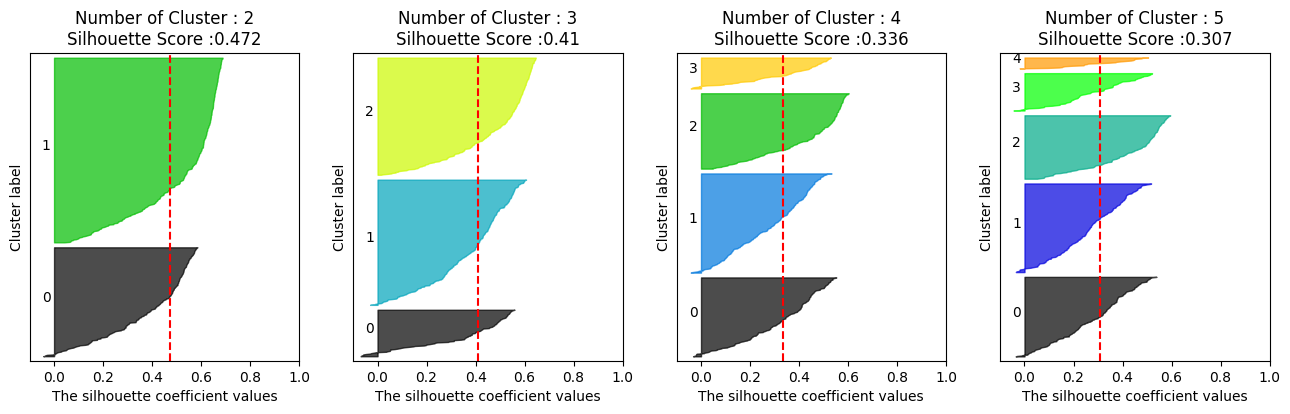

In [11]:
# 실루엣 점수 확인
import silhouette_analysis as si
import importlib
importlib.reload(si)

si.visualize_silhouette([2, 3, 4, 5], X_scaled)

plt.show()

실루엣 확인 : 2,3,4,5 모두 음수값이 있음        
평균을 봤을 때, 2,3이 높고, 모양을 봤을 경우에는 3의 모양이 더 균일하게 보인다!     

2,3,4로 클러스터링 진행해보고 각 컬럼에서 각 클러스터의 분포를 박스플롯으로 확인해보기!

-> 클러스터들의 분포가 겹치지 않는다면 해당 k는 적절한 것으로 생각해도 된다! 

In [12]:
# 군집화 결과 분석 
k = 4

baseball_km = KMeans(n_clusters=k, random_state=42)
cluster = baseball_km.fit_predict(X_scaled) # 학습, 새로운 예측 동시에 가능 

# 데이터프레임 생성
df = pd.DataFrame(X_scaled, columns=X.columns)
df['cluster'] = cluster
df.head()

,HR,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster
0,-0.373128,0.976149,-0.074229,0.104176,1.108646,1.248725,1.204841,1.118807,1.214334,0
1,1.815064,1.897116,1.679891,1.054165,1.654227,1.929967,1.758231,1.894866,1.857449,3
2,0.147870,1.107616,0.619910,-0.160485,0.826902,0.611178,1.171415,1.139040,0.424202,0
3,1.919264,2.027750,1.982543,1.555727,1.943794,2.130165,2.031780,2.009248,1.994235,3
4,0.877268,1.113814,1.177062,0.421269,0.776410,0.449003,0.575692,0.983538,0.554133,0


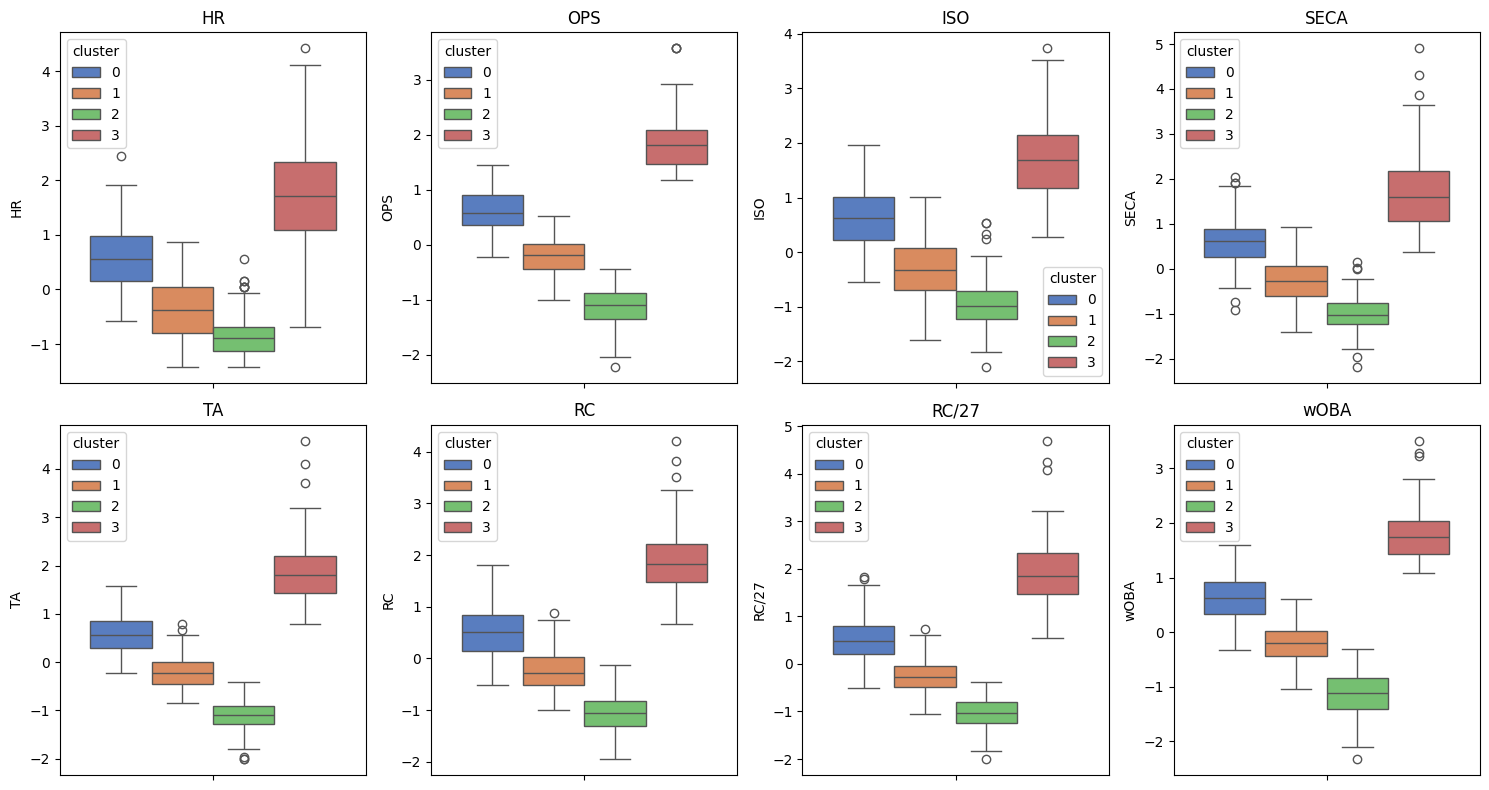

In [13]:
# 군집의 데이터 특징 분석
cols = df.columns[:-2]

plt.figure(figsize=(15,8))
for i, col in enumerate(cols):
    plt.subplot(2,4,i+1)
    sns.boxplot(data=df, y=col, hue='cluster', palette='muted')
    plt.title(col)
plt.tight_layout()

3개, 4개 모두 박스플롯 상으로도 봤을 때 잘 구분이 된다.     
3개)        
0번 > 1번 > 2번 순으로 지표가 좋다      
4개)        
4번 > 0번 > 1번 > 2번 순으로 지표가 좋다

#### 추가 실습) 클러스터 별 중심이 되는 선수 찾기

In [14]:
# 데이터프레임에 개별 데이터 실루엣 계수 컬럼 추가
df['silhouette'] = silhouette_samples(X_scaled, cluster)
df.head(2)

,HR,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,silhouette
0,-0.373128,0.976149,-0.074229,0.104176,1.108646,1.248725,1.204841,1.118807,1.214334,0,0.363756
1,1.815064,1.897116,1.679891,1.054165,1.654227,1.929967,1.758231,1.894866,1.857449,3,0.457270


In [15]:
# 잘못 군집화 된 클러스터
df.loc[df['silhouette']<0]

,HR,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,silhouette
9,1.189867,1.395062,1.507827,0.730896,0.980965,1.477069,1.159698,1.321978,1.420936,3,-0.035410
51,0.877268,1.418101,1.006983,0.885979,1.482684,1.246756,1.464470,1.442076,1.201784,3,-0.042025
93,1.294066,1.385821,1.284857,0.873615,1.340440,1.102252,1.466390,1.365648,1.093473,3,-0.026026
153,0.252070,0.226749,0.324993,0.239357,0.104231,0.068229,-0.159359,0.318290,0.134811,0,-0.020370
218,1.085667,1.339458,1.043044,1.092171,1.378643,1.269341,1.488217,1.295335,1.234266,3,-0.007880
222,-1.102525,-0.394513,-1.088282,-0.917685,-0.362292,-0.832925,-0.307401,-0.304732,-0.904531,1,-0.037736
265,-0.685727,-0.579964,-0.699132,-1.293184,-0.843801,-0.286542,-0.499556,-0.678211,-0.381538,1,-0.041945
301,-0.477327,0.616197,0.103586,0.195551,0.570480,-0.273317,0.519208,0.725956,-0.416446,0,-0.019794
303,0.877268,1.478546,1.148953,1.256862,1.422169,1.151865,1.456826,1.474988,1.042534,3,-0.008371
322,0.356270,0.282385,0.809966,0.533127,0.179624,-0.512671,0.033803,0.084829,-0.442496,0,-0.017229


In [16]:
# 클러스터 별 중심 player
# 실루엣 점수가 가장 높은 선수가 클러스터의 중심이다

df['player'] = y
df.loc[df.groupby('cluster')['silhouette'].idxmax(), 'player']

626     2014이택근
529     2012나지완
338     2007진갑용
3      2000송지만 
Name: player, dtype: object

### Kmeans + PCA

1) 일단 모든 컬럼 가지고 PCA 수행
* 각 PC별 공분산 확인 -> 가장 설명력이 높은 feature 2개로 클러스터링

In [17]:
# 전체 주성분 계산
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca 

array([[ 2.24106058e+00, -1.72255348e+00,  1.24436494e-01, ...,
         9.83425952e-02, -4.99862285e-02, -1.25401546e-02],
       [ 5.18436246e+00, -7.05195037e-02,  5.14545539e-01, ...,
         3.65858252e-02, -5.31069969e-02,  1.59459228e-02],
       [ 1.99960665e+00, -6.88610817e-01, -2.51897728e-01, ...,
         1.78832696e-02, -4.55600825e-02, -3.40283068e-02],
       ...,
       [-5.51160538e-01,  1.81702972e-01, -7.14731305e-01, ...,
         6.27230196e-02, -1.61606063e-02,  3.19630707e-02],
       [-4.12341647e+00, -1.88073555e-01,  5.00643604e-01, ...,
        -1.14579769e-01,  7.86430629e-03,  2.35274946e-03],
       [-3.50945790e+00,  1.07404620e-01, -4.20783372e-01, ...,
        -3.93754087e-02,  1.84239415e-02, -1.55918535e-02]],
      shape=(649, 9))

In [18]:
# 컬럼별 설명된 분산 비율 확인
explained_variance = pca.explained_variance_ratio_
explained_variance

array([8.84357731e-01, 6.73912324e-02, 2.46853594e-02, 1.76068099e-02,
       2.82275541e-03, 2.37250623e-03, 4.75833786e-04, 1.63476251e-04,
       1.24295991e-04])

In [19]:
# 누적분산 확인
cumulative_variance = explained_variance.cumsum()
cumulative_variance

array([0.88435773, 0.95174896, 0.97643432, 0.99404113, 0.99686389,
       0.99923639, 0.99971223, 0.9998757 , 1.        ])

PC 2번까지 선택하면 설명력 0.95 -> 2개만 선택해도 충분할 것

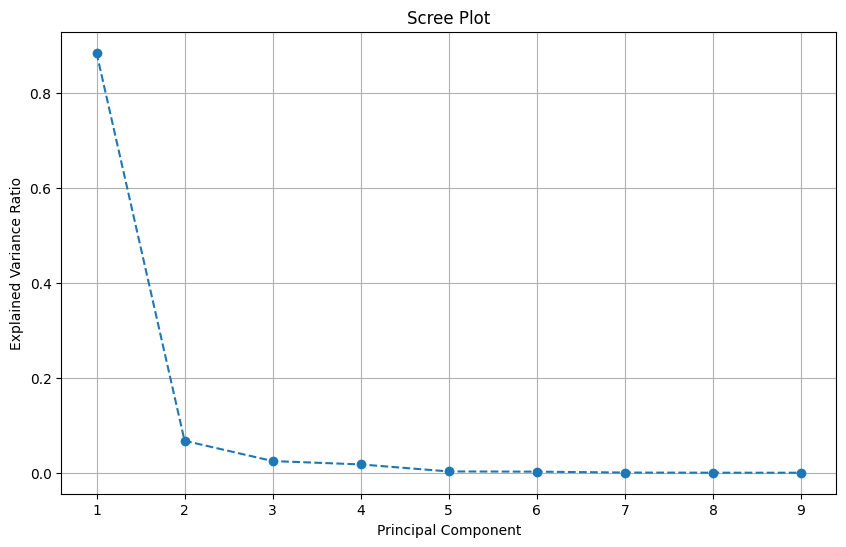

In [20]:
# Plot Scree Chart
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance) + 1, 1))
plt.grid()
plt.show()

In [21]:
# 최적의 주성분 개수 선택 (예: 95% 이상의 분산을 설명하는 최소 주성분 개수)
# 아까와 다르게 component 개수를 설정한 PCA 객체 생성 후 다시 학습
pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)
X_pca_2

array([[ 2.24106058, -1.72255348],
       [ 5.18436246, -0.0705195 ],
       [ 1.99960665, -0.68861082],
       ...,
       [-0.55116054,  0.18170297],
       [-4.12341647, -0.18807356],
       [-3.5094579 ,  0.10740462]], shape=(649, 2))

In [22]:
# PCA 설명된 분산 비율 출력
pca_2.explained_variance_ratio_

array([0.88435773, 0.06739123])

In [23]:
pca_2.explained_variance_.cumsum()

array([7.97150232, 8.5789594 ])

In [24]:
# pc1, pc2로 결과 데이터프레임 생성 
df_pca = pd.DataFrame(X_pca_2, columns=['pca_x', 'pca_y'])
df_pca.head(10)

,pca_x,pca_y
0,2.241061,-1.722553
1,5.184362,-0.070520
2,1.999607,-0.688611
3,5.866499,0.019275
4,2.305581,0.409168
5,2.673477,-0.480248
6,2.865953,-1.299388
7,-0.467827,-1.253143
8,1.359363,-0.569854
9,3.726329,0.065706


In [25]:
df_pca = pd.concat([df, df_pca], axis=1)
df_pca.head()

,HR,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,silhouette,player,pca_x,pca_y
0,-0.373128,0.976149,-0.074229,0.104176,1.108646,1.248725,1.204841,1.118807,1.214334,0,0.363756,2000박종호,2.241061,-1.722553
1,1.815064,1.897116,1.679891,1.054165,1.654227,1.929967,1.758231,1.894866,1.857449,3,0.457270,2000김동주,5.184362,-0.070520
2,0.147870,1.107616,0.619910,-0.160485,0.826902,0.611178,1.171415,1.139040,0.424202,0,0.419111,2000브리또,1.999607,-0.688611
3,1.919264,2.027750,1.982543,1.555727,1.943794,2.130165,2.031780,2.009248,1.994235,3,0.529934,2000송지만,5.866499,0.019275
4,0.877268,1.113814,1.177062,0.421269,0.776410,0.449003,0.575692,0.983538,0.554133,0,0.526556,2000데이비스,2.305581,0.409168


In [30]:
# 선택한 PC로 주성분으로 군집화
# k는 아까와 비교하기 위해 그대로 4로 설정
k = 4
baseball_km = KMeans(n_clusters=k, random_state=42)
cluster_pca = baseball_km.fit_predict(X_pca_2) # 학습, 새로운 예측 동시에 가능 
df_pca['cluster_pca'] = cluster_pca

In [31]:
df_pca.head()

,HR,OPS,ISO,SECA,TA,RC,RC/27,wOBA,XR,cluster,silhouette,player,pca_x,pca_y,cluster_pca
0,-0.373128,0.976149,-0.074229,0.104176,1.108646,1.248725,1.204841,1.118807,1.214334,0,0.363756,2000박종호,2.241061,-1.722553,0
1,1.815064,1.897116,1.679891,1.054165,1.654227,1.929967,1.758231,1.894866,1.857449,3,0.457270,2000김동주,5.184362,-0.070520,3
2,0.147870,1.107616,0.619910,-0.160485,0.826902,0.611178,1.171415,1.139040,0.424202,0,0.419111,2000브리또,1.999607,-0.688611,0
3,1.919264,2.027750,1.982543,1.555727,1.943794,2.130165,2.031780,2.009248,1.994235,3,0.529934,2000송지만,5.866499,0.019275,3
4,0.877268,1.113814,1.177062,0.421269,0.776410,0.449003,0.575692,0.983538,0.554133,0,0.526556,2000데이비스,2.305581,0.409168,0


### 군집 결과 시각화

<Axes: xlabel='pca_x', ylabel='pca_y'>

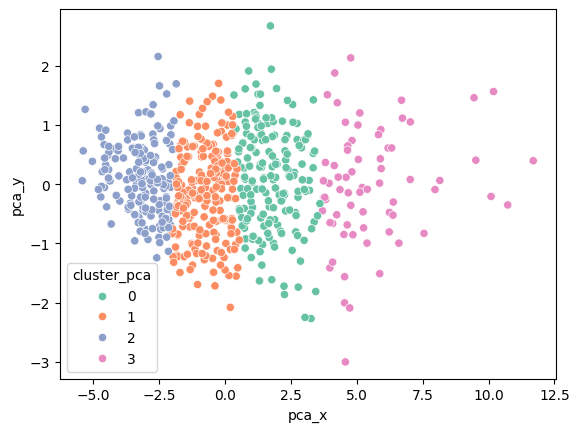

In [32]:
sns.scatterplot(df_pca, x='pca_x', y='pca_y',
                hue='cluster_pca',
                palette= 'Set2')

In [33]:
# PCA를 전후 군집 결과 비교
df_pca[['cluster', 'cluster_pca']].value_counts()

cluster  cluster_pca
1        1              226
0        0              180
2        2              172
3        3               71
Name: count, dtype: int64

In [34]:
pca_2.explained_variance_ratio_

array([0.88435773, 0.06739123])

아마 주성분 2개만으로도 95% 정도의 설명력을 가지기 때문에 PCA를 하더라도 원본데이터의 정보가 잘 보존된 것..?

### 번외)

1군 선수들의 명단 중 상위 10명정도 이름 출력해보기 

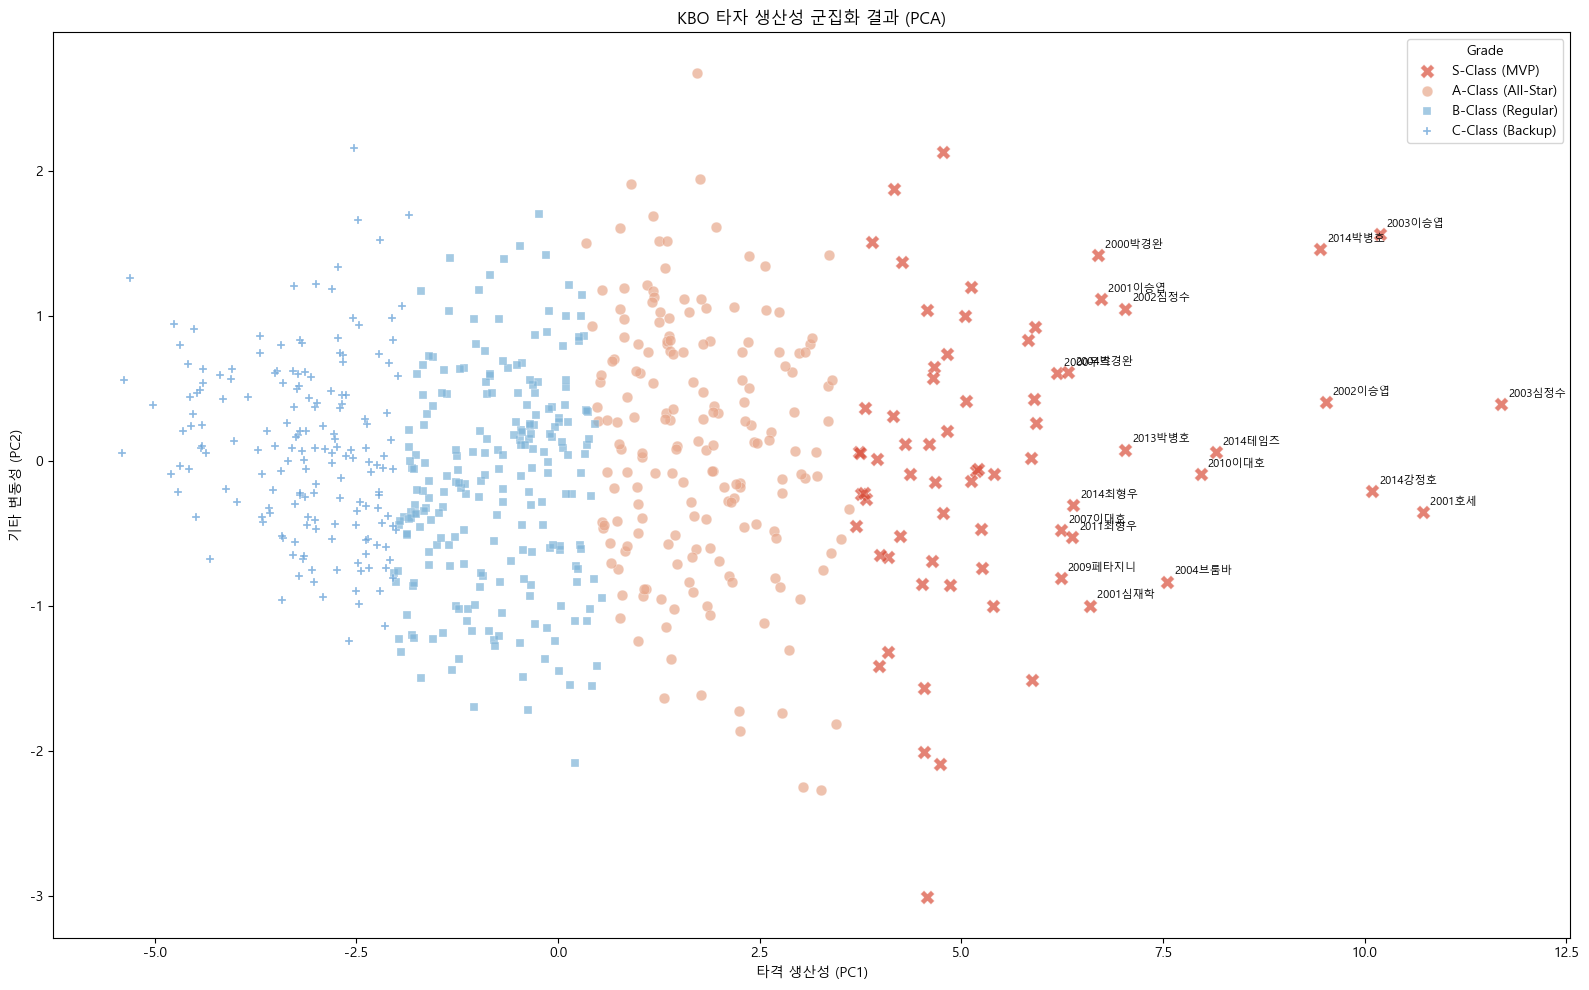

In [42]:
# 1. 군집별 PC1 평균으로 등급 순서 매기기 (PC1이 높을수록 타격 생산성이 좋다고 가정)
cluster_order = df_pca.groupby('cluster_pca')['pca_x'].mean().sort_values(ascending=False)
grade_map = {cluster_order.index[i]: grade 
             for i, grade in enumerate(['S-Class (MVP)', 'A-Class (All-Star)', 
                                         'B-Class (Regular)', 'C-Class (Backup)'])}
df_pca['Grade'] = df_pca['cluster_pca'].map(grade_map)

# 2. 등급별 마커/색상 설정
style_map = {
    'S-Class (MVP)':      {'marker': 'X', 'color': '#D94F3B', 's': 100},
    'A-Class (All-Star)': {'marker': 'o', 'color': '#E8A88C', 's': 60},
    'B-Class (Regular)':  {'marker': 's', 'color': '#7EB4D8', 's': 40},
    'C-Class (Backup)':   {'marker': 'P', 'color': '#5B9BD5', 's': 40},
}

# 3. 시각화
plt.figure(figsize=(16, 10))
plt.rcParams['font.family'] = 'Malgun Gothic'  # Mac: AppleGothic
plt.rcParams['axes.unicode_minus'] = False

for grade, style in style_map.items():
    subset = df_pca[df_pca['Grade'] == grade]
    plt.scatter(subset['pca_x'], subset['pca_y'],
                marker=style['marker'], c=style['color'],
                s=style['s'], label=grade, alpha=0.7, edgecolors='white', linewidth=0.3)


# 4. PC1 기준 상위 20명 이름 표기
top20 = df_pca.nlargest(20, 'pca_x')
for _, row in top20.iterrows():
    plt.annotate(row['player'], (row['pca_x'], row['pca_y']),
                 fontsize=8, ha='left', va='bottom',
                 xytext=(5, 3), textcoords='offset points')

plt.xlabel('타격 생산성 (PC1)')
plt.ylabel('기타 변동성 (PC2)')
plt.title('KBO 타자 생산성 군집화 결과 (PCA)')
plt.legend(title='Grade', loc='upper right')
plt.tight_layout()
plt.show()

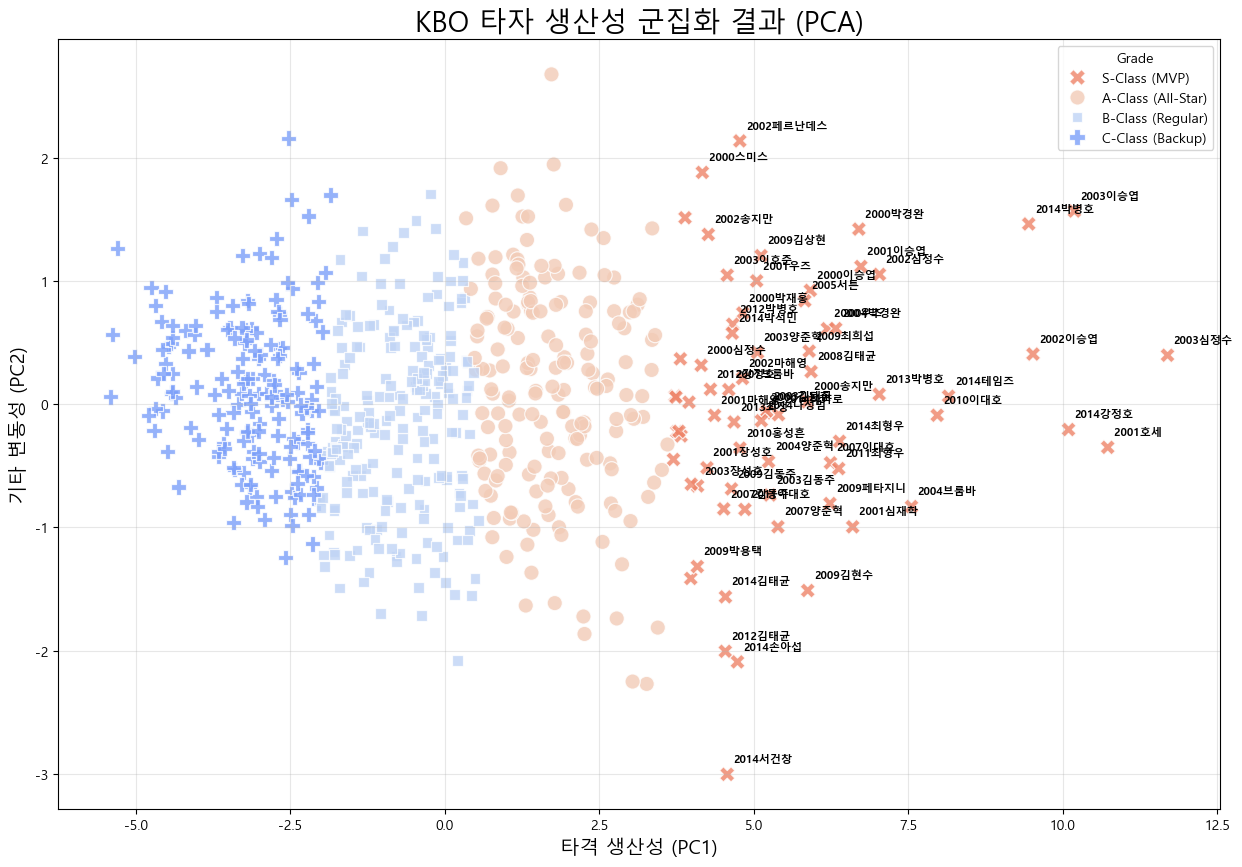
이런 그래프 출력해보기 